Frame rate and jitter analysis within ifm3d
========================

`ifm3d` provides two tools for helping to quantify expected frame rate and jitter from a given camera with a specific set of imager settings. These are `ifm3d hz` for measuring *actual* frame rate and `ifm3d jitter` for quantifying expected jitter.

There are several factors that contribute to frame rate and jitter. Some are systemic like the number of frequencies, the number of exposures, imager resolution, and the requested frame rate. These, of course, need to be tempered by the overall duty cycle of the active illumination unit on the device to keep within eye safety standards. Other factors involved in *actual* frame rate and jitter are things like the computational power inside of the camera itself and the ethernet bandwidth of both the camera and recieving computer. Finally, factors like the PCIC schema used (i.e., which image types we are transmitting from the camera back to `ifm3d`) *and* the type of image buffer used within `ifm3d` could also play a role and are not independent of the aforementioned items.

In this document, we will use a concrete example of specific imager settings across two different ifm cameras, the O3D and the O3X. We will use the tools supplied with `ifm3d` to conduct an analysis on both frame rate and jitter with these particular imager settings. We need to be clear, the imager settings used in this document are for exemplary purposes only and to help us draw some conclusions to get a better understanding of our expected frame rate and jitter when using `ifm3d` and the O3D or the O3X. We do not recommend the particular imager settings used in this document as suitable for any particular application. These are for exemplary purposes only. 


The tools
-----------

Before we get started, let's get acquainted with the tools. The first tool we will use in this document is `ifm3d hz`. It is used to get a sense of the actual frame rate from a running camera. Its help output is as follows:

```
$ ifm3d hz --help
usage: ifm3d [<global options>] hz [<hz options>]

global options:
  -h [ --help ]            Produce this help message and exit
  --ip arg (=192.168.0.69) IP address of the sensor
  --xmlrpc-port arg (=80)  XMLRPC port of the sensor
  --password arg           Password for establishing an edit-session with the 
                           sensor

hz options:
  --nframes arg (=10)   Number of frames to capture
  --nruns arg (=1)      Number of runs to compute summary statistics over
  --sw                  Software Trigger the FrameGrabber

```

The second tool we will use is `ifm3d jitter`. This tool allows us to perform a jitter analysis from a running camera across whichever supported `ifm3d` image containers you have compiled into your binary. The `ifm3d jitter` help output is as follows:

```
 $ ifm3d jitter --help
usage: ifm3d [<global options>] jitter [<jitter options>]

global options:
  -h [ --help ]            Produce this help message and exit
  --ip arg (=192.168.0.69) IP address of the sensor
  --xmlrpc-port arg (=80)  XMLRPC port of the sensor
  --password arg           Password for establishing an edit-session with the 
                           sensor

jitter options:
  --nframes arg (=100)  Number of frames to capture
  --outfile arg (=-)    Raw data output file, if not specified, nothing is 
                        written
```

As noted above, `ifm3d jitter` computes the jitter metrics for each image container you have built into your binaries. For purposes of this document, our `cmake` build line looked like `cmake -DCMAKE_INSTALL_PREFIX=/usr -DBUILD_MODULE_OPENCV=ON ..` So, in our `ifm3d jitter` output, we will gather statistics for the `ifm3d::ByteBuffer`, `ifm3d::ImageBuffer`, and `ifm3d::OpenCVBuffer`. Let's quickly discuss what this means so we can properly interpret our data. The `ifm3d::ByteBuffer` is the baseline container used in the `ifm3d` framegrabber module. Statistics related to the `ifm3d::ByteBuffer` gives us metrics on acquiring data from the camera, packetizing it locally, and signaling our control thread that data are ready. However, no parsing of the pixel bytes or image container construction is done. In theory, this should be the *fastest* albeit the most useless. The `ifm3d::ImageBuffer` constructs images prior to signaling the control thread. In the event the PCIC schema specified the Cartesian Data (i.e., the point cloud to be computed on the camera and transmitted over the wire to `ifm3d`) the `ifm3d::ImageBuffer` will create point cloud data structures as both a PCL point cloud and an OpenCV image (3 channels, one for each of the x, y, z spatial planes). Finally, the `ifm3d::OpenCVBuffer` is very similar to `ifm3d::ImageBuffer` except it does not create PCL bindings, only OpenCV. So, to be clear, depending upon the image container used and the PCIC schema specified, different amounts of work is done by the `ifm3d` library. We should keep this in mind when looking at our frame rate and jitter statistics.

The PCIC schemas used
------------------------

A PCIC schema specifies which image types should be computed by the camera and transmitted back to `ifm3d` for processing. In this document, we use two schemas for exemplary purposes. The first is `10`, which looks like:

```
$ ifm3d schema --mask=10
mask=10, str=-
---
PCIC (O3D-compatible): 

      {
        "layouter": "flexible",
        "format"  : {"dataencoding":"ascii"},
        "elements":
         [
           {"type":"string", "value":"star", "id":"start_string"},
           {"type":"blob", "id":"normalized_amplitude_image"},
           {"type":"blob", "id":"x_image"},
           {"type":"blob", "id":"y_image"},
           {"type":"blob", "id":"z_image"},
           {"type":"blob", "id":"confidence_image"},
           {"type":"blob", "id":"extrinsic_calibration"},
           {"type":"string", "value":"stop", "id":"end_string"}
         ]
      }
   
---
XML-RPC (O3X-compatible): 

      {
         "Apps":
         [
           {
             "Index":"1",
             "OutputDistanceImage":"false",
             "OutputAmplitudeImage":"true",
             "OutputGrayscaleImage":"false",
             "OutputXYZImage":"true",
             "OutputConfidenceImage":"true"
            }
         ]
      }

```

As shown above the `10` mask gives us the normalized amplitude and Cartesian data (point cloud computed by the camera and transmitted over the wire back to `ifm3d`). Additionally, the confidence and extrinsic calibration (o3d) data is transmitted as `ifm3d` enforces this as an invariant.

The second schema we use is `3`, which looks like:

```
$ ifm3d schema --mask=3
mask=3, str=-
---
PCIC (O3D-compatible): 

      {
        "layouter": "flexible",
        "format"  : {"dataencoding":"ascii"},
        "elements":
         [
           {"type":"string", "value":"star", "id":"start_string"},
           {"type":"blob", "id":"distance_image"},
           {"type":"blob", "id":"normalized_amplitude_image"},
           {"type":"blob", "id":"confidence_image"},
           {"type":"blob", "id":"extrinsic_calibration"},
           {"type":"string", "value":"stop", "id":"end_string"}
         ]
      }
   
---
XML-RPC (O3X-compatible): 

      {
         "Apps":
         [
           {
             "Index":"1",
             "OutputDistanceImage":"true",
             "OutputAmplitudeImage":"true",
             "OutputGrayscaleImage":"false",
             "OutputXYZImage":"false",
             "OutputConfidenceImage":"true"
            }
         ]
      }
```

As is shown above, in this case, we return the invariants and just the normalized amplitude and radial distance image. Assuming we have access to the unit vectors, such a schema would support point cloud computation off-board the camera.

For purposes of this document, the selection of these two schemas allows us to reason about frame rate and jitter as a function of camera-side computation, data transmission over the wire, and pixel/byte-parsing PC-side (i.e., in `ifm3d`).

The imager settings used
----------------------------

The pertinent imager settings we contemplate in this document across both the O3D and O3X include a frame rate of `10` Hz, an imager type of `upto30m_moderate` (which means, two frequencies and two exposures), a long exposure time of `550` usecs, and an exposure time ratio of `50`. We also note that for our O3D tests, we use the standard 23k pixel imager and for the O3X the 38k pixel imager. Full json outputs from running `ifm3d dump` for both the O3D and O3X are made available in the same documentation directory as this Jupyter notebook.

O3D Analysis
=======

We start our analysis with the O3D. Let's first get a sense of actual frame rate for both the `10` and `3` schemas:

```
$ IFM3D_SCHEMA=10 ifm3d hz --nframes=100
FrameGrabber running at: 9.99464 Hz
100 frames captured, over 1 runs

$ IFM3D_SCHEMA=3 ifm3d hz --nframes=100
FrameGrabber running at: 10.0418 Hz
100 frames captured, over 1 runs
```

We can see that with the above mentioned imager settings, the O3D can deliver the data and `ifm3d` can process it at 10 Hz. Let's look at the jitter across each image container for each schema.

```
$ IFM3D_SCHEMA=10 ifm3d jitter --outfile=o3d_10.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   99.53 ms
Median: 98.785 ms
Stdev:  4.47569 ms
Mad:    3.82193 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   99.37 ms
Median: 98.7394 ms
Stdev:  4.2418 ms
Mad:    1.88054 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   99.37 ms
Median: 98.9808 ms
Stdev:  3.52471 ms
Mad:    0.676537 ms
Raw data has been written to: o3d_10.csv

$ IFM3D_SCHEMA=3 ifm3d jitter --outfile=o3d_3.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   99.53 ms
Median: 98.7732 ms
Stdev:  4.34067 ms
Mad:    2.0731 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   99.26 ms
Median: 98.884 ms
Stdev:  4.69274 ms
Mad:    4.04442 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   99.44 ms
Median: 98.9005 ms
Stdev:  3.96812 ms
Mad:    1.30175 ms
Raw data has been written to: o3d_3.csv

```

We can see that `ifm3d jitter` outputs the *mean*, *median*, *standard deviation*, and the *median absolute error (MAD)*. For purposes of this document, we will focus on the *median* and the *mad*. Justification for looking at these statistics specifically, is best described in [this whitepaper](http://zeromq.org/whitepapers:measuring-jitter). To this end, for exemplary purposes, let's interpret the meaning of this output for the `3` schema and the `ifm3d::OpenCVBuffer` image container. We can say, *"the most typical deviation from the most typical latency of 98.9005 ms will be 1.30175 ms"*.

In our above command lines, we also asked `ifm3d jitter` to ouput the raw data so we can visualize it. Let's do that now.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

def plot_raw(infile, title=''):
    df = pd.read_csv(infile, sep=',', header=0)
    ax = df.plot(marker='.', linestyle='', grid=True, title=title)
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Latency (ms)")
    return df

def plot_pct(df, title):
    df2 = df.quantile(q=np.linspace(0,1,df.shape[0]))
    ax = df2.plot(marker='x', linestyle='', grid=True, title=title)
    ax.set_xlabel("% of sample")
    ax.set_ylabel("Latency (ms)")
    return df2

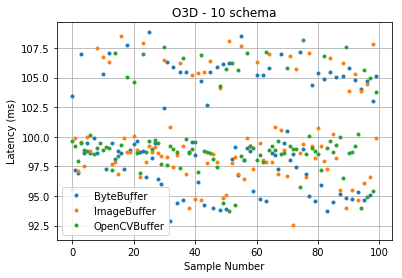

In [2]:
o3d10_df = plot_raw('o3d_10.csv', title="O3D - 10 schema")

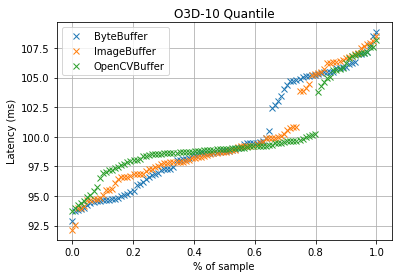

In [3]:
o3d10_dfq = plot_pct(o3d10_df, title="O3D-10 Quantile")

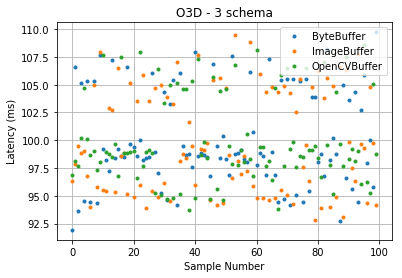

In [4]:
o3d3_df = plot_raw('o3d_3.csv', title="O3D - 3 schema")

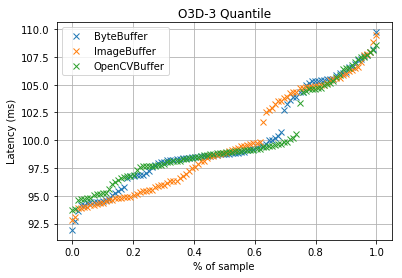

In [5]:
o3d3_dfq = plot_pct(o3d3_df, title="O3D-3 Quantile")

Now that we have all of our raw data plotted for both the `10` and `3` schemas as well as each of our available image containers, what can we say about this imager setting running on the O3D that the summary statistics to not reveal? First, we can see that there is certainly noticeable jitter and a clear separation around 100 - 101 ms of latency. These non-smooth curves seem to indicate that while the camera can deliver data at this rate and `ifm3d` can construct data containers for us, the imager setting is not well-behaved.

Additionally, to be clear on the quantile plots, the information we are conveying is the answer to the question: What is the worst latency to expect in N% of the cases? To do that, you look along the horizontal axis to pick N, then go up the vertical axis to get the answer.

O3X Analysis
=======

We now use the same imager settings as above from the O3D, but on the O3X.

```
$ IFM3D_SCHEMA=10 ifm3d hz --nframes=100
FrameGrabber running at: 6.25131 Hz
100 frames captured, over 1 runs

$ IFM3D_SCHEMA=3 ifm3d hz --nframes=100
FrameGrabber running at: 8.12579 Hz
100 frames captured, over 1 runs
```

The first thing that jumps out at us is that we cannot achieve the requested 10 Hz as we did with the O3D. Now, the problem can be with `ifm3d` or with the image computation on the O3X itself. We keep `ifm3d` as a candidate for the problem here as in this experiment we have the O3X delivering images at 38k pixels while the O3D is only at 23k pixels. Could parsing these extra pixels actually be the cause of our inability to achieve 10 Hz? Let's keep digging. But first some jitter analysis.

```
$ IFM3D_SCHEMA=10 ifm3d jitter --outfile=o3x_10_dualfreq.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   115.82 ms
Median: 107.025 ms
Stdev:  45.8692 ms
Mad:    5.08638 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   156.95 ms
Median: 146.929 ms
Stdev:  61.7167 ms
Mad:    11.6008 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   160.08 ms
Median: 153.086 ms
Stdev:  39.5972 ms
Mad:    7.95448 ms
Raw data has been written to: o3x_10_dualfreq.csv

$ IFM3D_SCHEMA=3 ifm3d jitter --outfile=o3x_3_dualfreq.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   157.85 ms
Median: 144.08 ms
Stdev:  61.9306 ms
Mad:    9.59409 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   148.16 ms
Median: 131.436 ms
Stdev:  74.1527 ms
Mad:    17.6944 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   158.03 ms
Median: 150.63 ms
Stdev:  49.4087 ms
Mad:    6.52549 ms
Raw data has been written to: o3x_3_dualfreq.csv

```

As we can see, there is a tremendous amount of jitter. Using the same example from above, if we look at the `3` schema and the `ifm3d::OpenCVBuffer`, we can say *"the most typical deviation from the most typical latency of 150.63 ms will be 6.25 ms"*. As we saw from above, looking at the raw data may reveal additional data patterns not made clear in the summary statistics. Let's look.


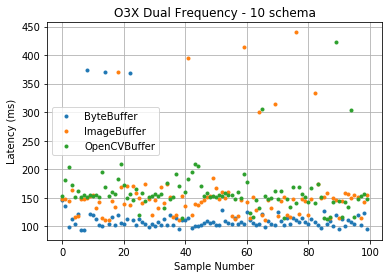

In [6]:
o3x10_dual_df = plot_raw('o3x_10_dualfreq.csv', title="O3X Dual Frequency - 10 schema")

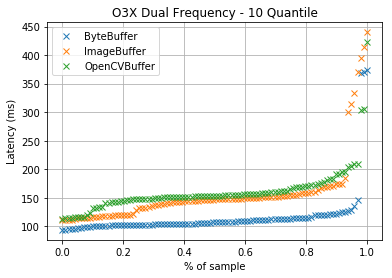

In [7]:
o3x10_dual_dfq = plot_pct(o3x10_dual_df, title="O3X Dual Frequency - 10 Quantile")

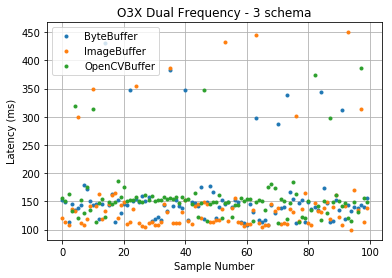

In [8]:
o3x3_dual_df = plot_raw('o3x_3_dualfreq.csv', title="O3X Dual Frequency - 3 schema")

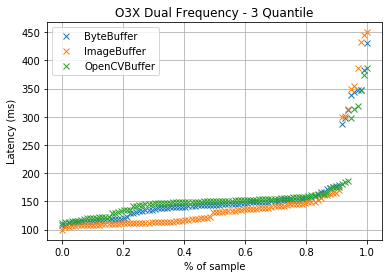

In [9]:
o3x3_dual_dfq = plot_pct(o3x3_dual_df, title="O3X Dual Frequency - 3 Quantile")

What conclusions can be drawn from these data? It is the opinion of this author, that it is not clear. Let's look at another configuration on the O3X. Specifically, we will keep all of the imager settings the same with the exception of running in a single frequency dual exposure mode instead of dual frequency dual exposure. This significantly cuts down the phase data processing on the O3X camera however, from the `ifm3d` perspective, the same amount of data need to be parsed and constructed into our image containers. To be clear, let's lessen the work on the camera, but keep the data processing load on the PC (`ifm3d`) side consistent.

```
$ IFM3D_SCHEMA=10 ifm3d hz --nframes=100
FrameGrabber running at: 9.59513 Hz
100 frames captured, over 1 runs

$ IFM3D_SCHEMA=3 ifm3d hz --nframes=100
FrameGrabber running at: 9.55734 Hz
100 frames captured, over 1 runs
```

The first thing we notice is that we can get get the data at 10 Hz now, which we could not do before in dual frequency mode. Let's compute the jitter statistics.

```
$ IFM3D_SCHEMA=10 ifm3d jitter --outfile=o3x_10_singlefreq.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   102.45 ms
Median: 103.007 ms
Stdev:  0.796807 ms
Mad:    0.279545 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   102.41 ms
Median: 102.941 ms
Stdev:  1.1547 ms
Mad:    0.462906 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   102.41 ms
Median: 102.986 ms
Stdev:  1.11393 ms
Mad:    0.259678 ms
Raw data has been written to: o3x_10_singlefreq.csv

$ IFM3D_SCHEMA=3 ifm3d jitter --outfile=o3x_3_singlefreq.csv
Capturing frame data for ifm3d::ByteBuffer...
Mean:   102.48 ms
Median: 103.016 ms
Stdev:  0.79091 ms
Mad:    0.224777 ms

Capturing frame data for ifm3d::ImageBuffer...
Mean:   102.46 ms
Median: 103.007 ms
Stdev:  0.801835 ms
Mad:    0.311375 ms

Capturing frame data for ifm3d::OpenCVBuffer...
Mean:   102.46 ms
Median: 102.993 ms
Stdev:  0.956567 ms
Mad:    0.425495 ms
Raw data has been written to: o3x_3_singlefreq.csv
```

We can see that these jitter numbers appear much more stable. To be consistent with above, we can see that for the `3` schema and the `ifm3d::OpenCVBuffer` *"the most typical deviation from the most typical latency of 102.993 ms will be .425495 ms"*.

Let's look at the raw data.

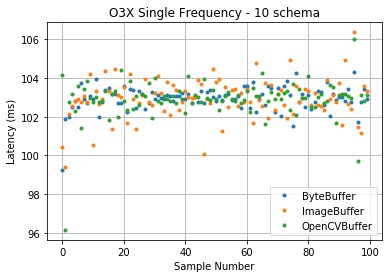

In [10]:
o3x10_single_df = plot_raw('o3x_10_singlefreq.csv', title="O3X Single Frequency - 10 schema")

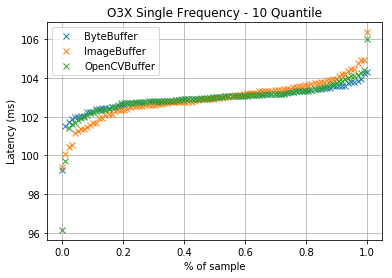

In [11]:
o3x10_single_dfq = plot_pct(o3x10_single_df, title="O3X Single Frequency - 10 Quantile")

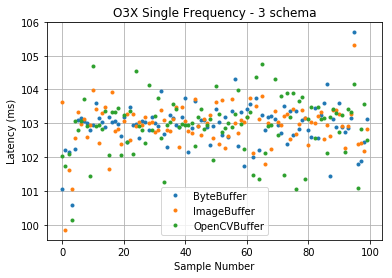

In [12]:
o3x3_single_df = plot_raw('o3x_3_singlefreq.csv', title="O3X Single Frequency - 3 schema")

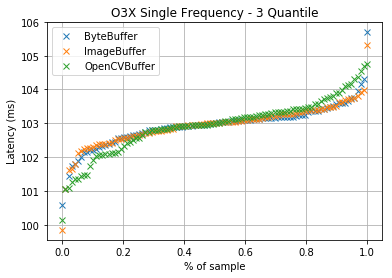

In [13]:
o3x3_single_dfq = plot_pct(o3x3_single_df, title="O3X Single Frequency - 3 Quantile")

These single frequency data on the O3X seem much more inline with a stable imager setting than we saw above with the O3X or O3D in dual frequency mode with these particular imager settings. Further conclusions are left as an exercise for the reader.

We must state again that the imager parameters used here for exemplary purposes are not endorsed in any way by ifm or the authors of this document as suitable for any particular application. They were simply used to help the reader experiment with the analytic tooling provided natively by `ifm3d`. Additionally, we remind the reader that all code and data used in this analysis are available in the `ifm3d` source repository.